In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from glob import glob

import sys
sys.path.append('..')

from maestro.stacker import Stacker
from maestro.frame import Frame

from maestro.offset_frames import compute_affine

Loading lights:   0%|          | 0/9 [00:00<?, ?it/s]

None


Loading biases:   0%|          | 0/20 [00:00<?, ?it/s]

Loading darks:   0%|          | 0/10 [00:00<?, ?it/s]

Loading flats:   0%|          | 0/20 [00:00<?, ?it/s]

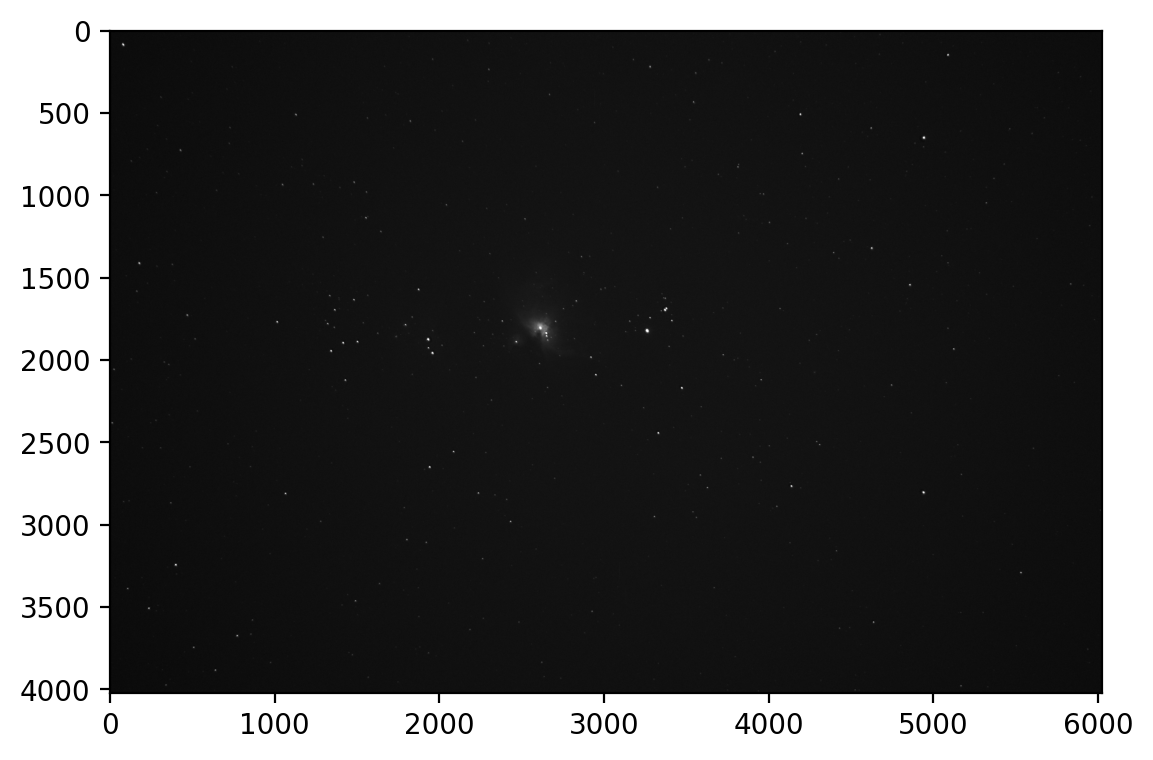

In [2]:
photo_dir = '../photos/'

stacker = Stacker(folder_path=photo_dir, keep_intermediate=True)
print(stacker.frame_load_kwargs)

stacker.create_master_frame('bias');
stacker.create_master_frame('dark');
stacker.create_master_frame('flat');

stacker.lights[0].show()

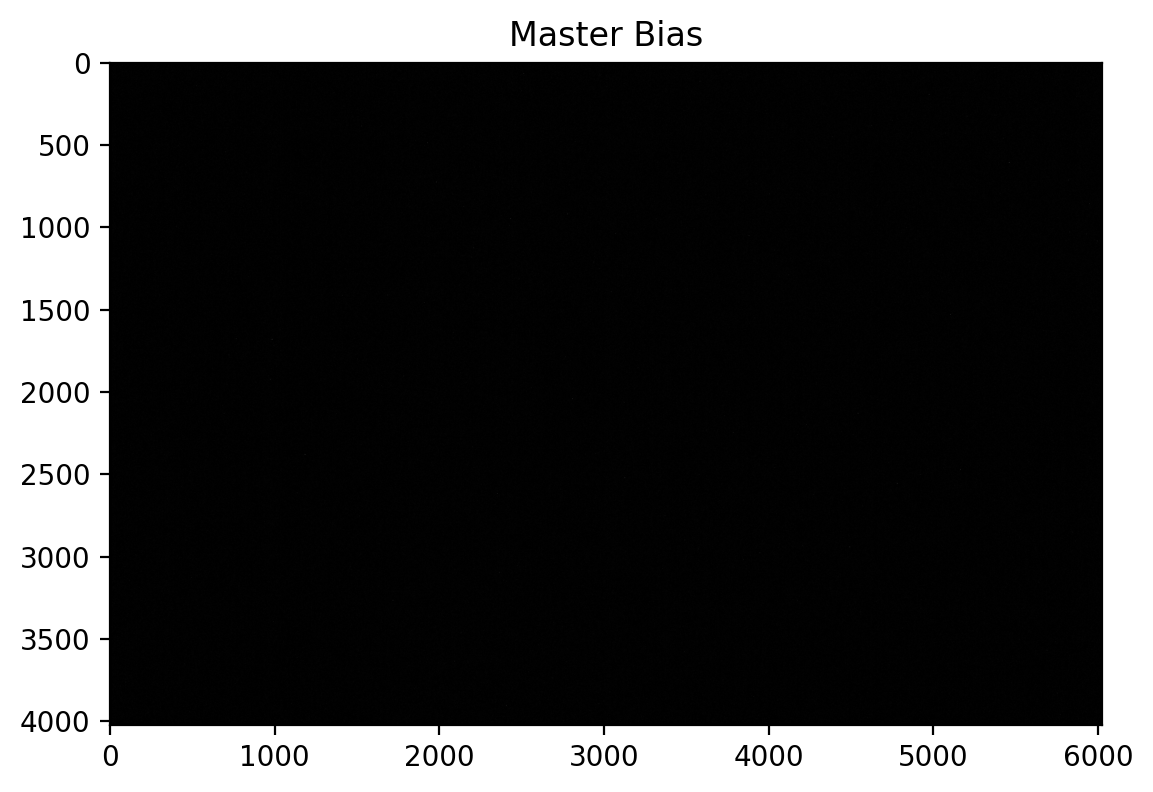

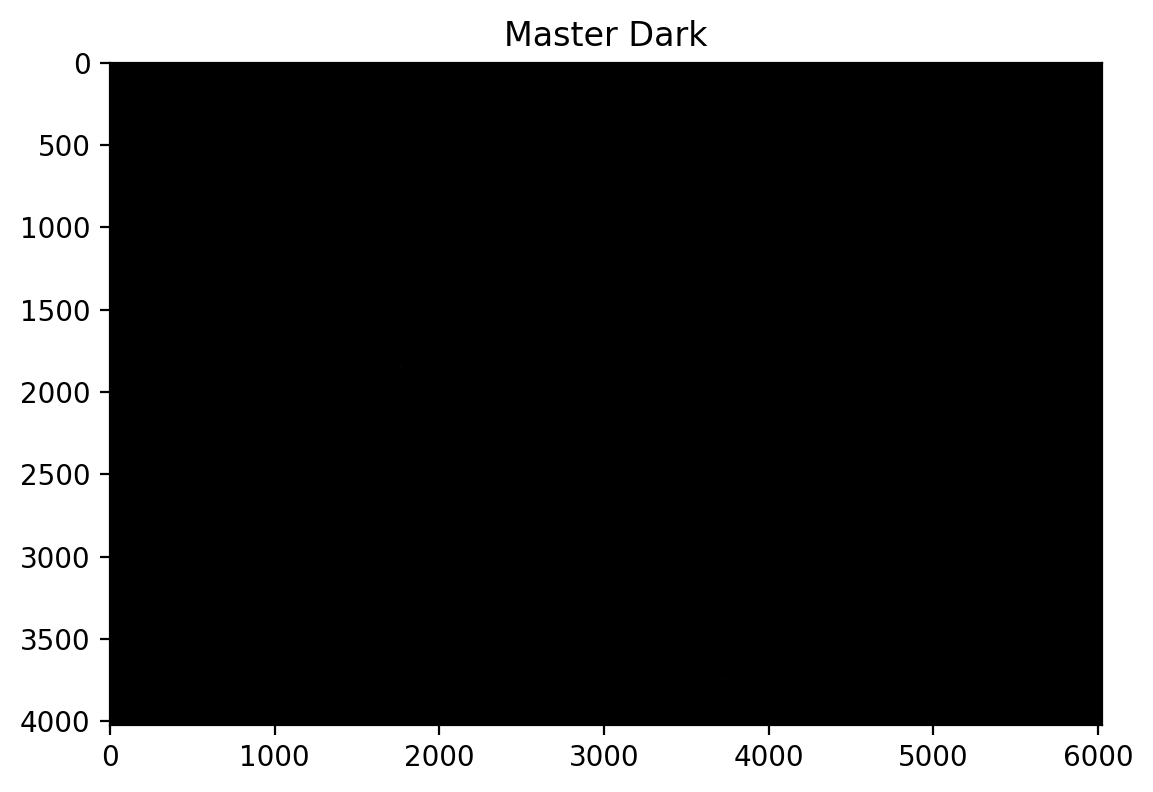

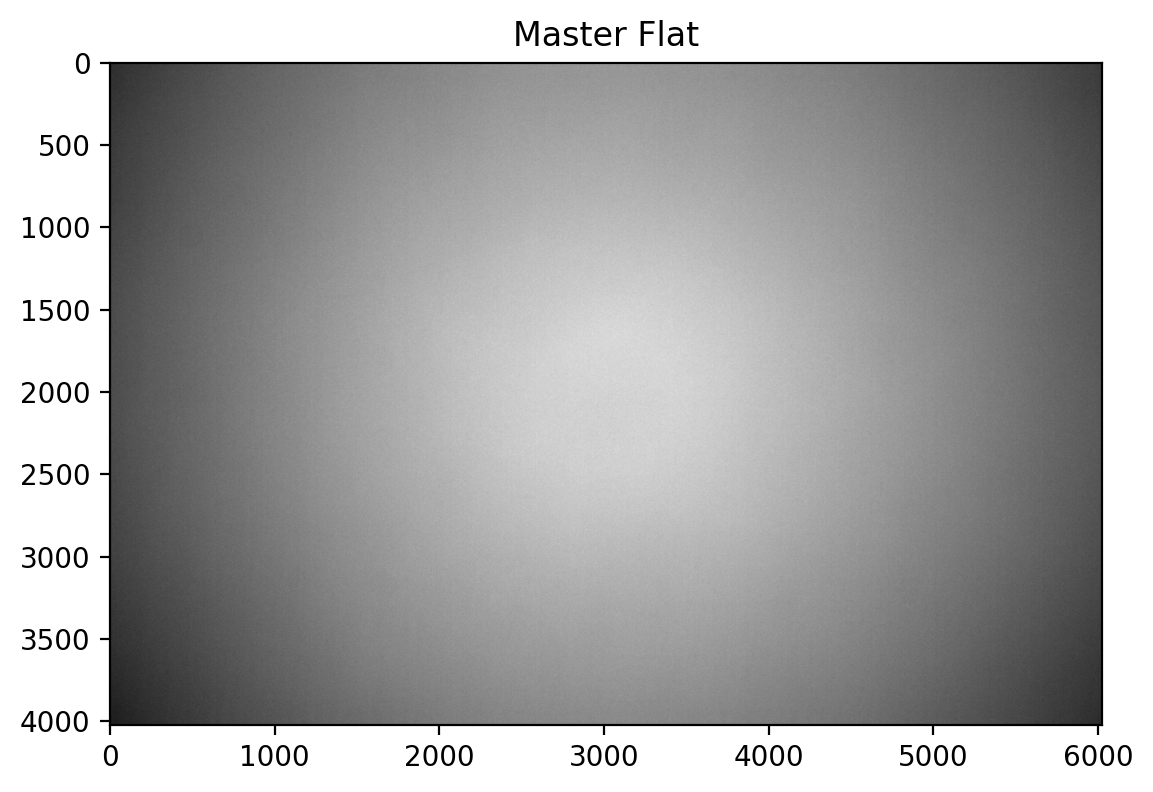

In [3]:
stacker.master_bias.show(True)
plt.title('Master Bias')
plt.show()

stacker.master_dark.show(True)
plt.title('Master Dark')
plt.show()

stacker.master_flat.show(True)
plt.title('Master Flat')
plt.show()

## Light noise reduction

The pixel response equation:

$$ N_{\rm{total}}(t) = R(C_{\rm{th}}(T,t) + C_{\rm{src}}(t)) + N_{\rm{read}} $$

Where t is the time in seconds of the exposure, $N_{\rm{total}}(t)$ is the measured sub-pixel values (usually 0-255) as a function of exposure time, $R(C)$ is the response function which converts the photon counts into a sub-pixel values, $C_{\rm{th}}(T,t)$ are the thermal photons which come from the camera's temperature $T$ as a function of exposure time, $C_{\rm{src}}(t)$ is the number of photons from the source and sky as a function of exposure time, and $N_{\rm{rd}}$ is the number of counts introduced into the sub-pixel by reading it. Importantly read noise is not time-dependent.

We can use this equation to estimate our final count response through a simple inversion if we assume that the response of a particular sub-pixel is linear function: $R(C_1 + C_2) = R(C_1) + R(C_2)$

$$ N_{\rm{total}}(t) = R(C_{\rm{th}}(T,t)) + R(C_{\rm{src}}(t)) + N_{\rm{read}} $$

$$ R(C_{\rm{src}}(t)) = N_{\rm{total}}(t) - R(C_{\rm{th}}(T,t)) + N_{\rm{read}} $$

We can make another small assumption that the response function itself is proportional to the photon count, such that $R(C) \propto r*C$. We then derive:

$$ r*C_{\rm{src}}(t) = N_{\rm{total}}(t) - r*C_{\rm{th}}(T,t) + N_{\rm{read}} $$

$$ C_{\rm{src}}(t) = \frac{N_{\rm{total}(t)} - r*C_{\rm{th}}(T,t) + N_{\rm{read}}}{r} $$

In this final equation, we can see that in order to estimate the total photon counts from our souce, $C_{\rm{src}}(t)$, we will need to solve for each sub-pixel. To do so, we will need 4 things:
1. $N_{\rm{total}}(t)$ - The total sub-pixel response
2. $r*C_{\rm{th}}(T,t)$ - The sub-pixel contributions from thermal photons as a function of the sub-pixel response
3. $N_{\rm{read}}$ - The sub-pixel contributions from read noise 
4. $r$ - The sub-pixel response function.

It may seem a bit odd to leave in the response $r$ in both the numerator and denominator, but, since we cannot isolate the effects of the response when measuring the thermal counts or read counts, it is much easier to keep them in this form and tranform them at the end. 

So how do we do this? With **light** **bias**, **dark**, and **flat** frames.

### Light frames

The most self explanatory type of frame is the light frame. These are the actual images of the object which you want to remove noise from. They contain all of the noise sources, but also all of the counts from the sources we want. 

$$ L = N_{\rm{total}}(t) $$


### Bias frames

The goal of the bias frames are to estimate the amount of noise introduced into the image by the camera reading the sub-pixel values. We can achieve this through setting our camera to take the shortest possible exposure time with a camera lens cap on. This isolates only the read noise since there isn't enough time or light for meaningful photon counts to accure, meaning that the only counts come from read noise.

Bias frames directly measure the sub-pixel read noise without any other noise sources

$$ B = N_{\rm{read}} $$

### Dark frames

Dark frames are our way of estimating the number of counts due to thermal noise. These are done by again covering our camera with a lense cap and photographing "nothing" with the exact same settings done with the lights. Importantly, these must be taken at the same temperature for accurate estimation. Dark frames still contain read noise, and contain the response function within them as well.

$$ D = r*C_{\rm{th}}(T,t) + N_{\rm{read}} $$


### Flat frames

Finally, flat frames aim to measure the response function of the sub-pixels. We can do this through uniform white images taken with some shorter exposure time but a brighter source. Most often, you can use a bright white light source with some sort of diffuser layer to ensure uniform brightness accross the lens. This can be done with a white flashlight, a white computer screen or other sources of white light (it is important that the contributions from red, green and blue are roughly even). Its also a good idea to use something like a plain white shirt as a diffuser to prevent hotspots of light. Flat frames also include read noise, but since they are taken with much brighter light sources and significantly shorter exposure times, the contributions made by thermal photons are minimal. 

While technically the response will be a function of the exposure time of the flats, in practice, unless accurate photon counts are required, we only care about the relative response. This means we only care about how each of the individual sub-pixels respond to the same brightness relative to eachother. This will remove many issues like vignetting. 

$$ F \propto r + N_{\rm{read}} $$


## Reduced lights

With all of this knowledge, we can now reduce the noise in our light frames to make **reduced lights** as a function of our other calibration frames:

$$ L_{\rm{reduced}} = \frac{L - (D - B) - B}{(F-B)} $$




In [4]:
light = stacker.lights[0]
dark = stacker.master_dark
bias = stacker.master_bias
flat = stacker.master_flat

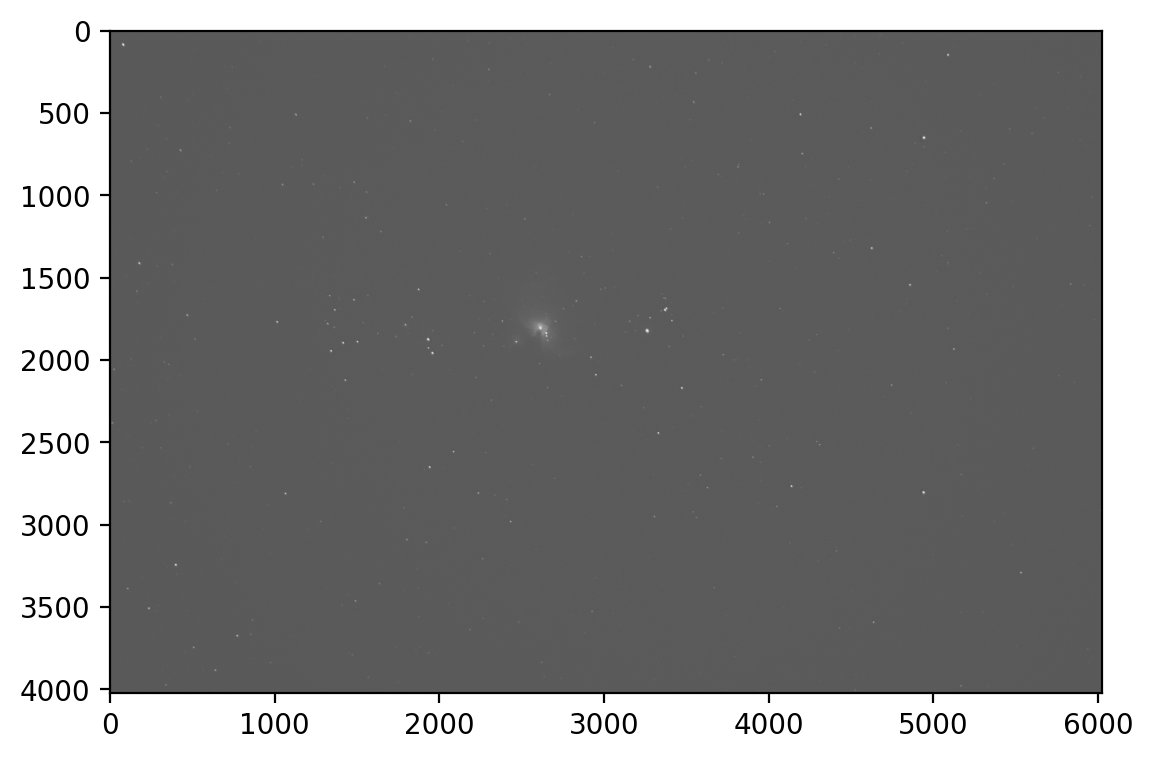

In [27]:
(10*reduced).show()